In [1]:
import albumentations as A
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import torch
from albumentations.pytorch import ToTensorV2
from collections import defaultdict
from tqdm import tqdm

from modules import *
from networks import *
from training import *

COORDS = 'polar'  # cartesian, polar
ARCH = 'dual'  # dual, cascade
MODEL = 'ref'  # rau, ref, swin

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

SIZE = 256 if MODEL != 'swin' else 224
transform = A.Compose([
    A.Resize(height=SIZE, width=SIZE, interpolation=cv.INTER_AREA),
    A.Lambda(image=sharpen, p=1.0),
    A.Lambda(image=polar_transform, mask=polar_transform),
    A.Normalize(),
    ToTensorV2(),
])

loader = load_dataset(
    ['../data/DRISHTI/ROI/TestImages'],
    ['../data/DRISHTI/ROI/TestMasks'],
    transform,
    batch_size=1,
    shuffle=False,
)

path = rf"..\models\{COORDS}\{MODEL}\binary.pth"
checkpoint = load_checkpoint(path, map_location=device)
base_model = checkpoint['model']
base_model = base_model.eval()

path = rf"..\models\{COORDS}\{MODEL}\{ARCH}.pth"
checkpoint = load_checkpoint(path, map_location=device)
model = checkpoint['model']
model = model.eval()

Loaded dataset with 51 samples in 51 batches.
=> Loading checkpoint: ..\models\polar\ref\binary.pth
=> Loading checkpoint: ..\models\polar\ref\dual.pth


In [11]:
from collections import defaultdict


def get_threshold_stats(mode, model, loader):
    data = []

    model.eval()
    with torch.no_grad():
        for images, masks in loader:
            preds, probs, loss = predict(mode, model, images, masks)
            od_probs = probs[:, 0, :, :]
            oc_probs = probs[:, 1, :, :]

            data.append((images, masks, od_probs, oc_probs))

    thresholds = np.linspace(0, 1, 101)

    tp_od = np.zeros_like(thresholds)
    tn_od = np.zeros_like(thresholds)
    fp_od = np.zeros_like(thresholds)
    fn_od = np.zeros_like(thresholds)

    tp_oc = np.zeros_like(thresholds)
    tn_oc = np.zeros_like(thresholds)
    fp_oc = np.zeros_like(thresholds)
    fn_oc = np.zeros_like(thresholds)

    for i, thresh in enumerate(thresholds):
        for images, masks, od_probs, oc_probs in data:
            od_preds = (od_probs > thresh).long()
            oc_preds = (oc_probs > thresh).long()

            preds = torch.zeros_like(oc_preds)
            preds[od_preds == 1] = 1
            preds[oc_preds == 1] = 2
            met = get_metrics(masks, preds, [[1, 2], [2]])

            tp_od[i] += met['tp_OD']
            tn_od[i] += met['tn_OD']
            fp_od[i] += met['fp_OD']
            fn_od[i] += met['fn_OD']

            tp_oc[i] += met['tp_OC']
            tn_oc[i] += met['tn_OC']
            fp_oc[i] += met['fp_OC']
            fn_oc[i] += met['fn_OC']

    metrics = defaultdict(lambda: np.zeros_like(thresholds))

    for i, (tp, tn, fp, fn) in enumerate(zip(tp_od, tn_od, fp_od, fn_od)):
        met = calculate_metrics(tp, tn, fp, fn)
        for k, v in met.items():
            metrics[f'{k}_OD'][i] = v

    for i, (tp, tn, fp, fn) in enumerate(zip(tp_oc, tn_oc, fp_oc, fn_oc)):
        met = calculate_metrics(tp, tn, fp, fn)
        for k, v in met.items():
            metrics[f'{k}_OC'][i] = v

    df = pd.DataFrame({'threshold': thresholds, **metrics})

    df['precision_OD'][100] = 1
    df['precision_OC'][100] = 1

    df['gmean_OD'] = np.sqrt(df['sensitivity_OD'] * df['specificity_OD'])
    df['gmean_OC'] = np.sqrt(df['sensitivity_OC'] * df['specificity_OC'])

    return df


def threshold_tuning_curve(df, tuning_metric: str = 'dice'):
    max_od_index = df[f'{tuning_metric}_OD'].idxmax()
    max_oc_index = df[f'{tuning_metric}_OC'].idxmax()

    best_threshold_od_tune = df['threshold'][max_od_index]
    best_threshold_oc_tune = df['threshold'][max_oc_index]

    plt.figure(figsize=(9, 6))
    plt.plot(df['threshold'], df[f'{tuning_metric}_OD'], label=f'OD {tuning_metric}')
    plt.plot(df['threshold'], df[f'{tuning_metric}_OC'], label=f'OC {tuning_metric}')
    plt.scatter(best_threshold_od_tune, df[f'{tuning_metric}_OD'][max_od_index], c='b',
                label=f'Best OD threshold: {best_threshold_od_tune:.2f}', zorder=3)
    plt.scatter(best_threshold_oc_tune, df[f'{tuning_metric}_OC'][max_oc_index], c='r',
                label=f'Best OC threshold: {best_threshold_oc_tune:.2f}', zorder=3)
    plt.xlabel('Threshold')
    plt.ylabel(tuning_metric.capitalize())
    plt.title(f'Threshold Tuning Curve for {tuning_metric.capitalize()}')
    plt.legend()
    plt.grid(True)
    plt.show()

    return best_threshold_od_tune, best_threshold_oc_tune


def roc_curve(df):
    od_distances = np.sqrt(df['fpr_OD'] ** 2 + (1 - df['sensitivity_OD']) ** 2)
    oc_distances = np.sqrt(df['fpr_OC'] ** 2 + (1 - df['sensitivity_OC']) ** 2)

    min_index_od = od_distances.idxmin()
    min_index_oc = oc_distances.idxmin()

    best_threshold_od_roc = df['threshold'][min_index_od]
    best_threshold_oc_roc = df['threshold'][min_index_oc]

    plt.figure(figsize=(9, 6))
    plt.plot(df['fpr_OD'], df['sensitivity_OD'], label='OD curve')
    plt.plot(df['fpr_OC'], df['sensitivity_OC'], label='OC curve')
    plt.scatter(df['fpr_OD'][min_index_od], df['sensitivity_OD'][min_index_od], c='b',
                label=f'Best OD threshold: {best_threshold_od_roc:.2f}', zorder=3)
    plt.scatter(df['fpr_OC'][min_index_oc], df['sensitivity_OC'][min_index_oc], c='r',
                label=f'Best OC threshold: {best_threshold_oc_roc:.2f}', zorder=3)
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

    return best_threshold_od_roc, best_threshold_oc_roc


def precision_recall_curve(df):
    precision_od = df['precision_OD']
    recall_od = df['sensitivity_OD']

    precision_oc = df['precision_OC']
    recall_oc = df['sensitivity_OC']

    od_distances = np.sqrt((1 - precision_od) ** 2 + (1 - recall_od) ** 2)
    oc_distances = np.sqrt((1 - precision_oc) ** 2 + (1 - recall_oc) ** 2)

    min_index_od = od_distances.idxmin()
    min_index_oc = oc_distances.idxmin()

    best_threshold_od_pr = df['threshold'][min_index_od]
    best_threshold_oc_pr = df['threshold'][min_index_oc]

    plt.figure(figsize=(9, 6))
    plt.plot(recall_od, precision_od, label='OD curve', marker='.')
    plt.plot(recall_oc, precision_oc, label='OC curve', marker='.')
    plt.scatter(recall_od[min_index_od], precision_od[min_index_od], c='b',
                label=f'Best OD threshold: {best_threshold_od_pr:.2f}', zorder=3)
    plt.scatter(recall_oc[min_index_oc], precision_oc[min_index_oc], c='r',
                label=f'Best OC threshold: {best_threshold_oc_pr:.2f}', zorder=3)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

    return best_threshold_od_pr, best_threshold_oc_pr


In [3]:
df = get_threshold_stats(ARCH, model, loader)
df

,threshold,accuracy_OD,precision_OD,npv_OD,sensitivity_OD,specificity_OD,fpr_OD,fnr_OD,dice_OD,iou_OD,...,fnr_OC,dice_OC,iou_OC,balance_accuracy_OC,tp_OC,tn_OC,fp_OC,fn_OC,gmean_OD,gmean_OC
0,0.00,0.401042,0.401042,0.000000,1.000000,0.000000,1.000000,0.000000,0.572491,0.401042,...,0.000000,0.450985,0.291143,0.500000,973097.0,0.0,2369239.0,0.0,0.000000,0.000000
1,0.01,0.974864,0.942839,0.998480,0.997818,0.959495,0.040505,0.002182,0.969549,0.940899,...,0.007798,0.898629,0.815919,0.951732,965509.0,2158997.0,210242.0,7588.0,0.978469,0.950871
2,0.02,0.978069,0.951215,0.997523,0.996419,0.965783,0.034217,0.003581,0.973292,0.947974,...,0.010364,0.911984,0.838208,0.957718,963012.0,2193442.0,175797.0,10085.0,0.980981,0.957186
3,0.03,0.979979,0.956519,0.996781,0.995322,0.969706,0.030294,0.004678,0.975535,0.952238,...,0.012546,0.919805,0.851518,0.960944,960889.0,2213894.0,155345.0,12208.0,0.982430,0.960578
4,0.04,0.981562,0.961156,0.996028,0.994205,0.973097,0.026903,0.005795,0.977401,0.955801,...,0.014583,0.925324,0.861026,0.963040,958906.0,2228658.0,140581.0,14191.0,0.983594,0.962780
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,0.96,0.964563,0.999861,0.944212,0.911766,0.999915,0.000085,0.088234,0.953783,0.911650,...,0.183962,0.894512,0.809156,0.906272,794084.0,2360963.0,8276.0,179013.0,0.954824,0.901769
97,0.97,0.962069,0.999937,0.940475,0.905476,0.999962,0.000038,0.094524,0.950365,0.905425,...,0.198967,0.885932,0.795223,0.899016,779483.0,2362129.0,7110.0,193614.0,0.951547,0.893661
98,0.98,0.958433,0.999980,0.935115,0.896370,0.999988,0.000012,0.103630,0.945345,0.896354,...,0.220261,0.873290,0.775080,0.888635,758762.0,2363389.0,5850.0,214335.0,0.946763,0.881938
99,0.99,0.951911,0.999997,0.925680,0.880092,0.999999,0.000001,0.119908,0.936221,0.880090,...,0.258018,0.849707,0.738687,0.870075,722020.0,2364899.0,4340.0,251077.0,0.938131,0.860594


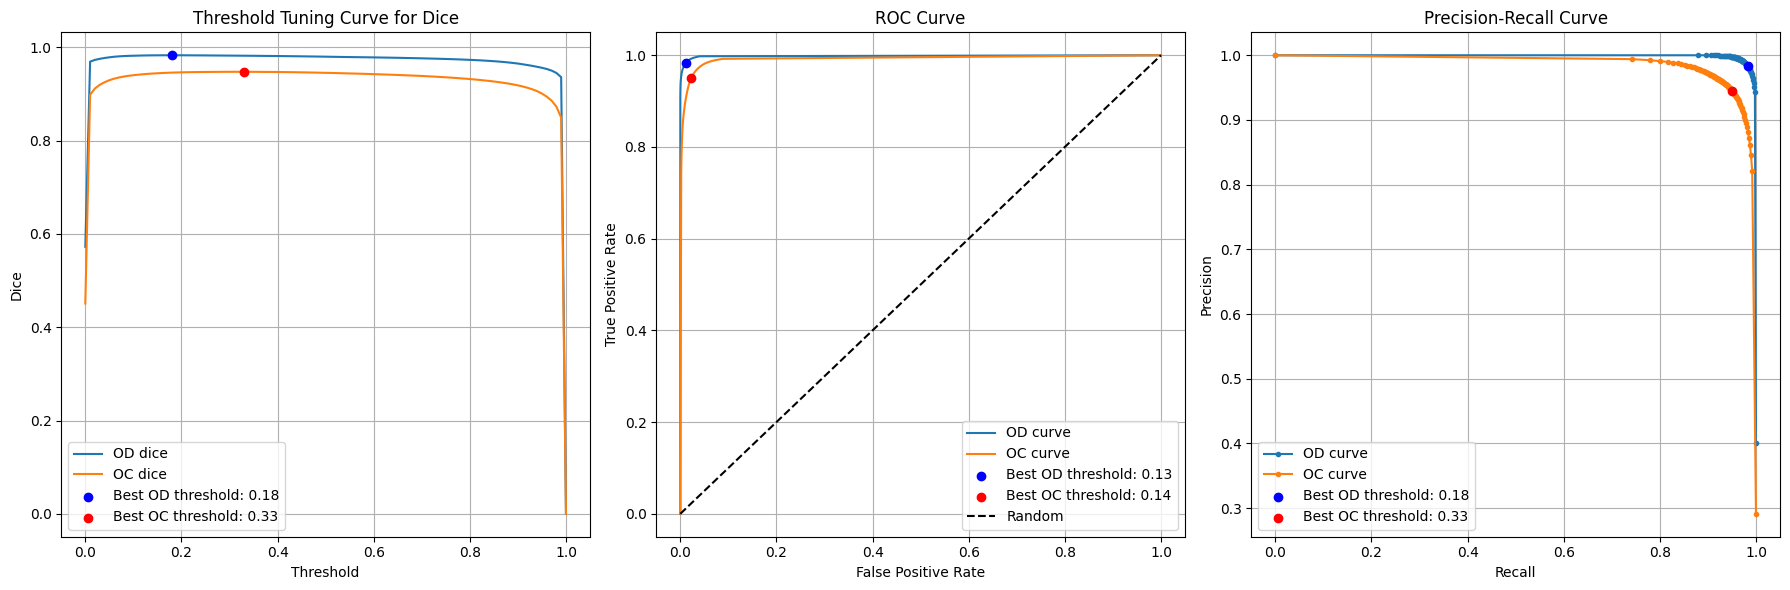

{'tuning': {'OD': 0.18, 'OC': 0.33},
 'roc': {'OD': 0.13, 'OC': 0.14},
 'pr': {'OD': 0.18, 'OC': 0.33}}

In [4]:
def plot_curves(df, tuning_metric='dice'):
    # Threshold Tuning
    max_od_index = df[f'{tuning_metric}_OD'].idxmax()
    max_oc_index = df[f'{tuning_metric}_OC'].idxmax()
    best_threshold_od_tune = df['threshold'][max_od_index]
    best_threshold_oc_tune = df['threshold'][max_oc_index]

    # ROC Curve
    od_distances = np.sqrt(df['fpr_OD'] ** 2 + (1 - df['sensitivity_OD']) ** 2)
    oc_distances = np.sqrt(df['fpr_OC'] ** 2 + (1 - df['sensitivity_OC']) ** 2)
    min_index_od = od_distances.idxmin()
    min_index_oc = oc_distances.idxmin()
    best_threshold_od_roc = df['threshold'][min_index_od]
    best_threshold_oc_roc = df['threshold'][min_index_oc]

    # Precision-Recall Curve
    precision_od = df['precision_OD']
    recall_od = df['sensitivity_OD']
    precision_oc = df['precision_OC']
    recall_oc = df['sensitivity_OC']
    od_distances = np.sqrt((1 - precision_od) ** 2 + (1 - recall_od) ** 2)
    oc_distances = np.sqrt((1 - precision_oc) ** 2 + (1 - recall_oc) ** 2)
    min_index_od = od_distances.idxmin()
    min_index_oc = oc_distances.idxmin()
    best_threshold_od_pr = df['threshold'][min_index_od]
    best_threshold_oc_pr = df['threshold'][min_index_oc]

    # Setup subplot layout
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

    # Threshold Tuning Curve
    axes[0].plot(df['threshold'], df[f'{tuning_metric}_OD'], label=f'OD {tuning_metric}')
    axes[0].plot(df['threshold'], df[f'{tuning_metric}_OC'], label=f'OC {tuning_metric}')
    axes[0].scatter(best_threshold_od_tune, df[f'{tuning_metric}_OD'][max_od_index], c='b',
                    label=f'Best OD threshold: {best_threshold_od_tune:.2f}', zorder=3)
    axes[0].scatter(best_threshold_oc_tune, df[f'{tuning_metric}_OC'][max_oc_index], c='r',
                    label=f'Best OC threshold: {best_threshold_oc_tune:.2f}', zorder=3)
    axes[0].set_xlabel('Threshold')
    axes[0].set_ylabel(tuning_metric.capitalize())
    axes[0].set_title(f'Threshold Tuning Curve for {tuning_metric.capitalize()}')
    axes[0].legend()
    axes[0].grid(True)

    # ROC Curve
    axes[1].plot(df['fpr_OD'], df['sensitivity_OD'], label='OD curve')
    axes[1].plot(df['fpr_OC'], df['sensitivity_OC'], label='OC curve')
    axes[1].scatter(df['fpr_OD'][min_index_od], df['sensitivity_OD'][min_index_od], c='b',
                    label=f'Best OD threshold: {best_threshold_od_roc:.2f}', zorder=3)
    axes[1].scatter(df['fpr_OC'][min_index_oc], df['sensitivity_OC'][min_index_oc], c='r',
                    label=f'Best OC threshold: {best_threshold_oc_roc:.2f}', zorder=3)
    axes[1].plot([0, 1], [0, 1], 'k--', label='Random')
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title('ROC Curve')
    axes[1].legend()
    axes[1].grid(True)

    # Precision-Recall Curve
    axes[2].plot(recall_od, precision_od, label='OD curve', marker='.')
    axes[2].plot(recall_oc, precision_oc, label='OC curve', marker='.')
    axes[2].scatter(recall_od[min_index_od], precision_od[min_index_od], c='b',
                    label=f'Best OD threshold: {best_threshold_od_pr:.2f}', zorder=3)
    axes[2].scatter(recall_oc[min_index_oc], precision_oc[min_index_oc], c='r',
                    label=f'Best OC threshold: {best_threshold_oc_pr:.2f}', zorder=3)
    axes[2].set_xlabel('Recall')
    axes[2].set_ylabel('Precision')
    axes[2].set_title('Precision-Recall Curve')
    axes[2].legend()
    axes[2].grid(True)

    plt.tight_layout()
    plt.show()

    return {
        'tuning': {
            'OD': best_threshold_od_tune,
            'OC': best_threshold_oc_tune,
        },
        'roc': {
            'OD': best_threshold_od_roc,
            'OC': best_threshold_oc_roc,
        },
        'pr': {
            'OD': best_threshold_od_pr,
            'OC': best_threshold_oc_pr,
        },
    }


plot_curves(df, tuning_metric='dice')

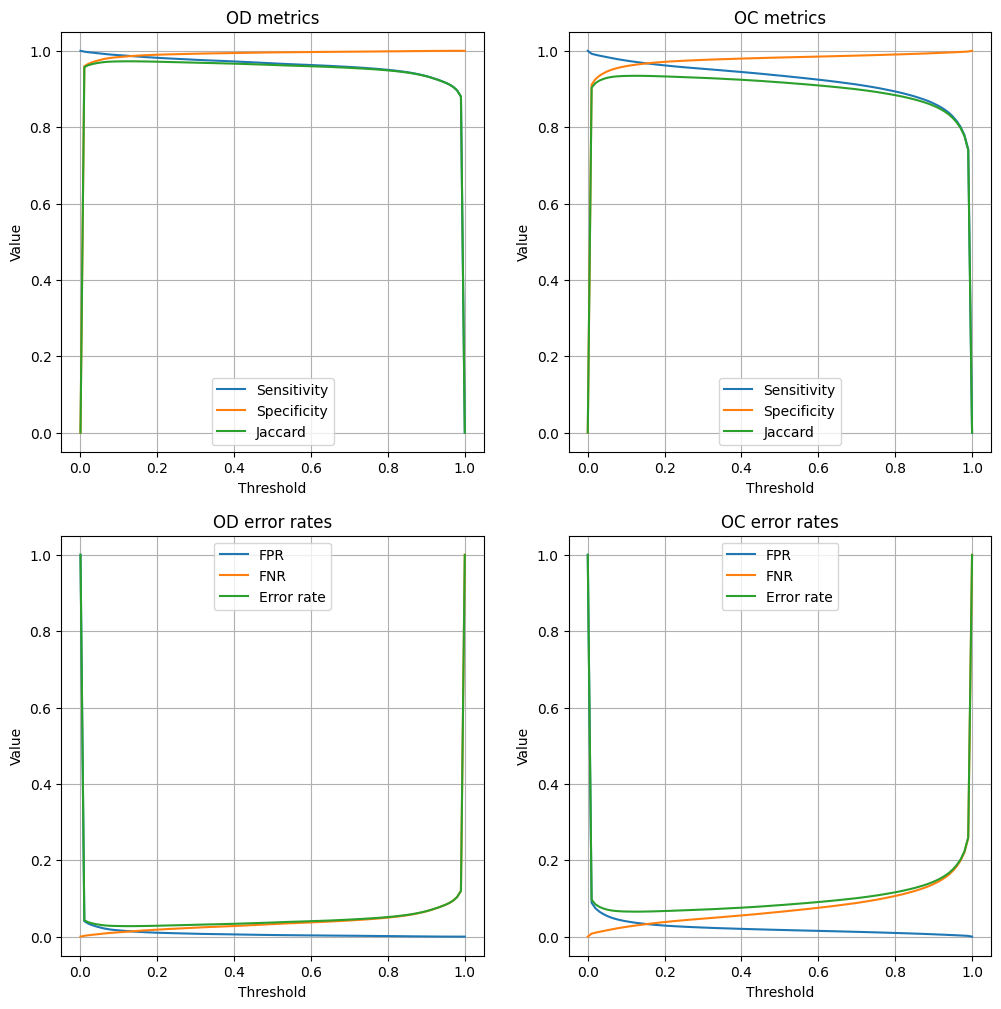

In [12]:
# Plot metrics
_, ax = plt.subplots(2, 2, figsize=(12, 12))

ax[0, 0].plot(df['threshold'], df['sensitivity_OD'], label='Sensitivity')
ax[0, 0].plot(df['threshold'], df['specificity_OD'], label='Specificity')
ax[0, 0].plot(df['threshold'], df['specificity_OD'] + df['sensitivity_OD'] - 1, label='Jaccard')
ax[0, 0].set_xlabel('Threshold')
ax[0, 0].set_ylabel('Value')
ax[0, 0].set_title('OD metrics')
ax[0, 0].legend()
ax[0, 0].grid(True)

ax[0, 1].plot(df['threshold'], df['sensitivity_OC'], label='Sensitivity')
ax[0, 1].plot(df['threshold'], df['specificity_OC'], label='Specificity')
ax[0, 1].plot(df['threshold'], df['specificity_OC'] + df['sensitivity_OC'] - 1, label='Jaccard')
ax[0, 1].set_xlabel('Threshold')
ax[0, 1].set_ylabel('Value')
ax[0, 1].set_title('OC metrics')
ax[0, 1].legend()
ax[0, 1].grid(True)

ax[1, 0].plot(df['threshold'], df['fpr_OD'], label='FPR')
ax[1, 0].plot(df['threshold'], df['fnr_OD'], label='FNR')
ax[1, 0].plot(df['threshold'], df['fpr_OD'] + df['fnr_OD'], label='Error rate')
ax[1, 0].set_xlabel('Threshold')
ax[1, 0].set_ylabel('Value')
ax[1, 0].set_title('OD error rates')
ax[1, 0].legend()
ax[1, 0].grid(True)

ax[1, 1].plot(df['threshold'], df['fpr_OC'], label='FPR')
ax[1, 1].plot(df['threshold'], df['fnr_OC'], label='FNR')
ax[1, 1].plot(df['threshold'], df['fpr_OC'] + df['fnr_OC'], label='Error rate')
ax[1, 1].set_xlabel('Threshold')
ax[1, 1].set_ylabel('Value')
ax[1, 1].set_title('OC error rates')
ax[1, 1].legend()
ax[1, 1].grid(True)

plt.show()

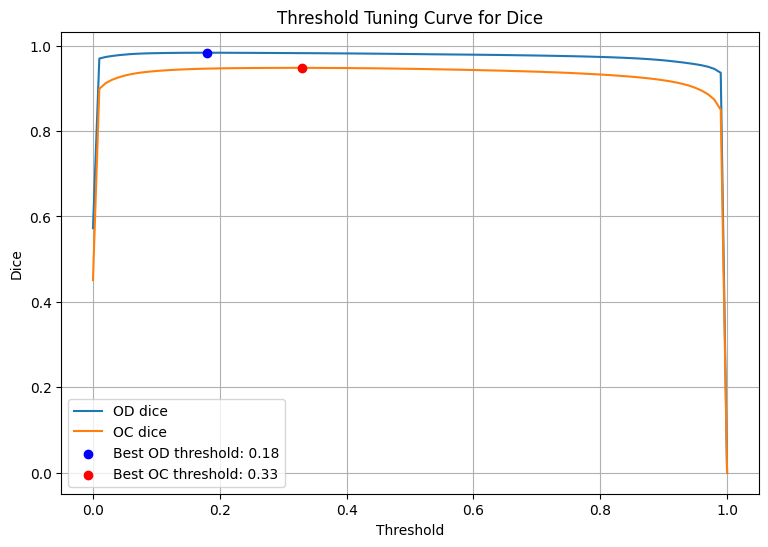

(0.18, 0.33)

In [13]:
threshold_tuning_curve(df, tuning_metric='dice')

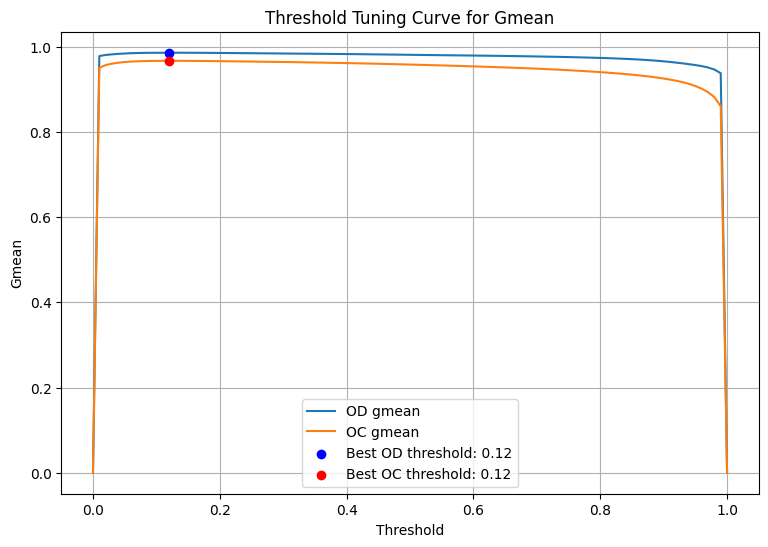

(0.12, 0.12)

In [14]:
threshold_tuning_curve(df, tuning_metric='gmean')

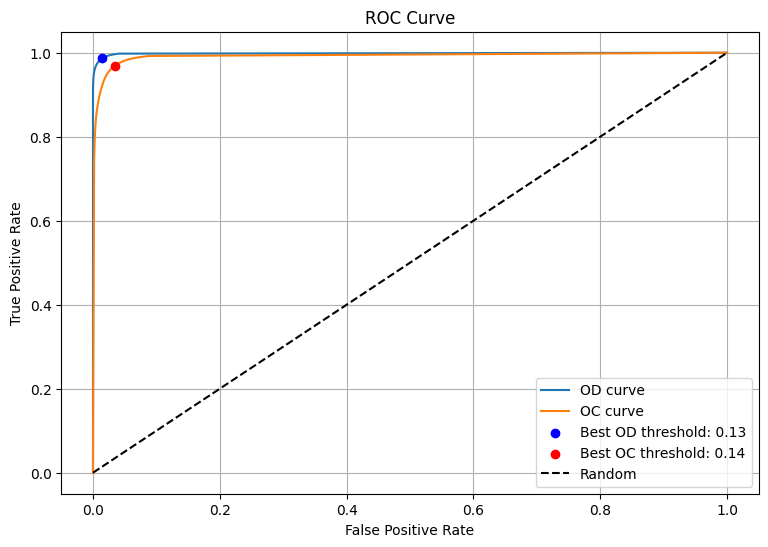

(0.13, 0.14)

In [15]:
roc_curve(df)

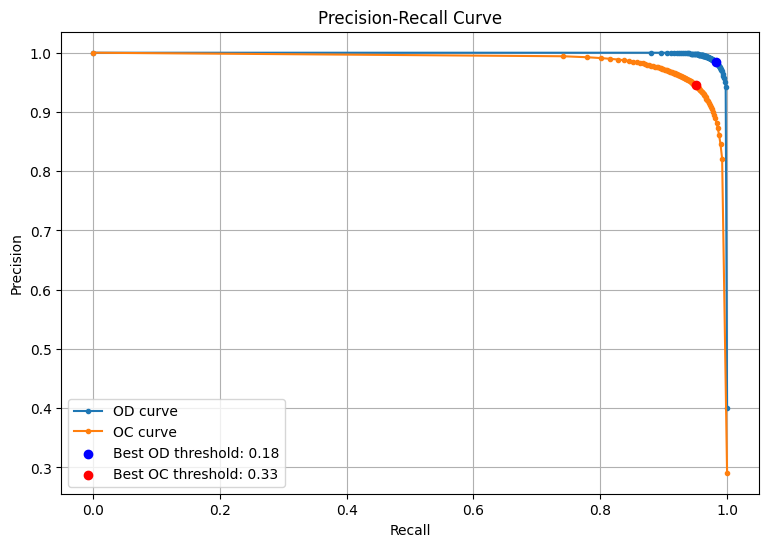

(0.18, 0.33)

In [16]:
precision_recall_curve(df)

In [23]:
evaluate(ARCH, model, loader, device, od_thresh=0.15, oc_thresh=0.25)

Evaluating dual segmentation: 100%|██████████| 51/51 [00:08<00:00,  6.15it/s, accuracy_OC=0.969, accuracy_OD=0.986, balance_accuracy_OC=0.968, balance_accuracy_OD=0.987, dice_OC=0.942, dice_OD=0.983, fn_OC=813, fn_OD=392, fnr_OC=0.0389, fnr_OD=0.0139, fp_OC=1.21e+3, fp_OD=496, fpr_OC=0.025, fpr_OD=0.0127, iou_OC=0.896, iou_OD=0.968, npv_OC=0.983, npv_OD=0.99, precision_OC=0.933, precision_OD=0.981, sensitivity_OC=0.961, sensitivity_OD=0.986, specificity_OC=0.975, specificity_OD=0.987, tn_OC=4.52e+4, tn_OD=3.88e+4, tp_OC=1.83e+4, tp_OD=2.59e+4]   


{'accuracy_OD': 0.986445707433364,
 'precision_OD': 0.9813900000604816,
 'npv_OD': 0.9896493033411685,
 'sensitivity_OD': 0.9860971010886568,
 'specificity_OD': 0.9872941053165685,
 'fpr_OD': 0.012705894683431623,
 'fnr_OD': 0.013902898911343158,
 'dice_OD': 0.9834708829616217,
 'iou_OD': 0.9677092541499018,
 'balance_accuracy_OD': 0.9866956032026125,
 'tp_OD': 25890.235294117647,
 'tn_OD': 38757.470588235294,
 'fp_OD': 495.84313725490193,
 'fn_OD': 392.45098039215685,
 'accuracy_OC': 0.9690509870940563,
 'precision_OC': 0.9326322895663272,
 'npv_OC': 0.9826671639212151,
 'sensitivity_OC': 0.9610644802007309,
 'specificity_OC': 0.974977832189981,
 'fpr_OC': 0.02502216781001896,
 'fnr_OC': 0.038935519799269014,
 'dice_OC': 0.9420529867404234,
 'iou_OC': 0.8959448769014491,
 'balance_accuracy_OC': 0.968021156195356,
 'tp_OC': 18267.019607843136,
 'tn_OC': 45240.705882352944,
 'fp_OC': 1214.9607843137255,
 'fn_OC': 813.3137254901961}

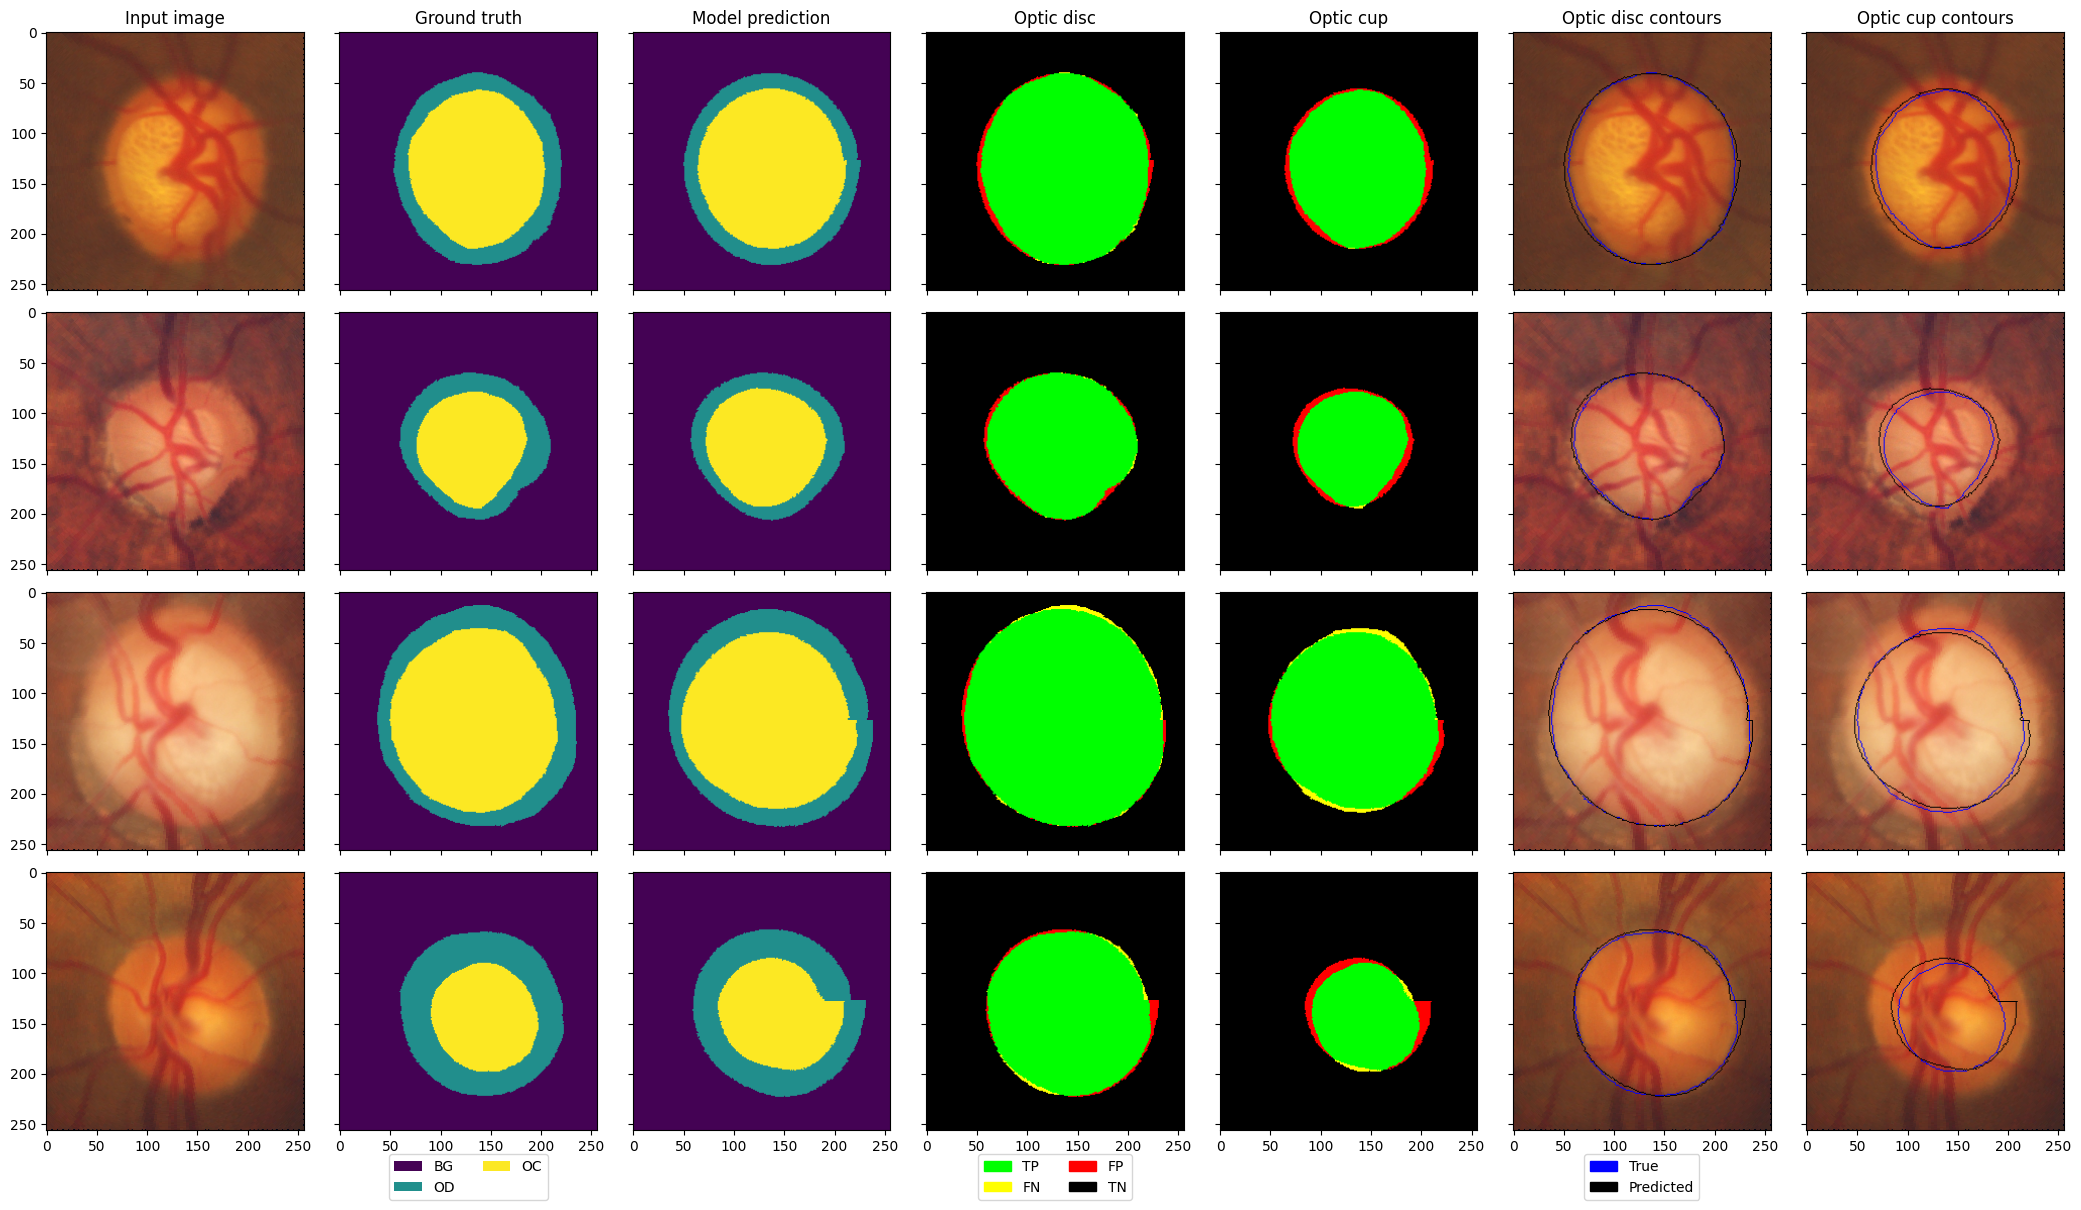

In [22]:
plot_results_from_loader(
    ARCH, loader, model, device,
    n_samples=4, od_thresh=0.15, oc_thresh=0.25,
    post_process_fn=postprocess,
    inter_process_fn=interprocess if ARCH == 'cascade' else None,
    inverse_transform=undo_polar_transform,
)

torch.Size([1, 3, 256, 256]) torch.Size([1, 256, 256])
torch.Size([1, 256, 256]) torch.Size([1, 2, 256, 256]) tensor(0.1145, device='cuda:0')


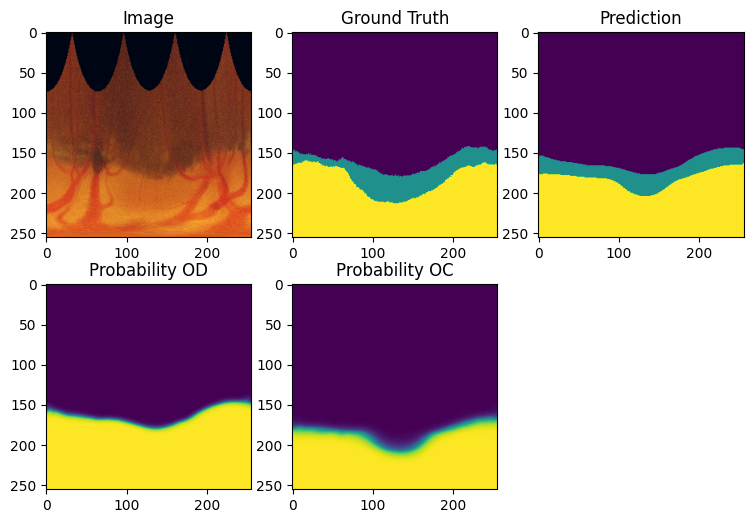

In [19]:
criterion = ComboLoss(1)

for images, masks in loader:
    images, masks = images.float(), masks.long()
    print(images.shape, masks.shape)
    preds, probs, loss = predict_dual(model, images, masks, device, criterion, od_threshold=0.2, oc_threshold=0.25)
    print(preds.shape, probs.shape, loss)

    for i in range(images.shape[0]):
        img = images[i].detach().cpu().numpy().transpose(1, 2, 0)
        img -= img.min()
        img /= img.max()
        mask = masks[i].detach().cpu().numpy()
        pred = preds[i].detach().cpu().numpy()
        prob = probs[i].detach().cpu().numpy()

        plt.figure(figsize=(9, 6))
        plt.subplot(2, 3, 1)
        plt.imshow(img)
        plt.title('Image')

        plt.subplot(2, 3, 2)
        plt.imshow(mask)
        plt.title('Ground Truth')

        plt.subplot(2, 3, 3)
        plt.imshow(pred)
        plt.title('Prediction')

        plt.subplot(2, 3, 4)
        plt.imshow(prob[0])
        plt.title('Probability OD')

        plt.subplot(2, 3, 5)
        plt.imshow(prob[1])
        plt.title('Probability OC')

        plt.subplot(2, 3, 6)
        plt.axis('off')

        plt.show()
    break